In [1]:
from pyspark.sql.types import (IntegerType, DoubleType, StringType)
import numpy as np
from pyspark.sql.functions import mean
from pyspark.sql.functions import col,udf,lit,expr,collect_set
import pyspark.sql.functions as F
from pyspark.sql.functions import (avg, col, countDistinct, split, isnan, when, count, udf, round as sqlround)
import math



df = spark.read.format("csv").option("header","true").load("hdfs://master:9000/user/tpt/data.csv")


#Label Encoding
def label_encode(df, input_col, output_col):
    distinct_values = df.select(input_col).distinct().collect()
    mapping = {row[input_col]: index for index, row in enumerate(distinct_values)}
    mapping_broadcast = spark.sparkContext.broadcast(mapping)
    def label_encode_udf(value):
        return mapping_broadcast.value.get(value, None)
    spark.udf.register("label_encode_udf", label_encode_udf, DoubleType())
    df = df.withColumn(output_col, lit(None).cast(DoubleType()))
    for value, index in mapping.items():
        condition = col(input_col) == lit(value)
        df = df.withColumn(output_col, when(condition, lit(index).cast(DoubleType())).otherwise(col(output_col)))
    df = df.drop(input_col).withColumnRenamed(output_col, input_col)
    return df

#Conver string to double
def convert_string_to_double(df, column_name):
    df = df.withColumn(column_name, col(column_name).cast(DoubleType()))
    return df

#Extract Year from Date
def extract_year_from_date(df, date_column, output_column):
    df = df.withColumn(output_column, expr(f"substring({date_column}, -4)"))
    return df


In [2]:
df.printSchema()

root
 |-- PRT_ID: string (nullable = true)
 |-- AREA: string (nullable = true)
 |-- INT_SQFT: string (nullable = true)
 |-- DATE_SALE: string (nullable = true)
 |-- DIST_MAINROAD: string (nullable = true)
 |-- N_BEDROOM: string (nullable = true)
 |-- N_BATHROOM: string (nullable = true)
 |-- N_ROOM: string (nullable = true)
 |-- SALE_COND: string (nullable = true)
 |-- PARK_FACIL: string (nullable = true)
 |-- DATE_BUILD: string (nullable = true)
 |-- BUILDTYPE: string (nullable = true)
 |-- UTILITY_AVAIL: string (nullable = true)
 |-- STREET: string (nullable = true)
 |-- MZZONE: string (nullable = true)
 |-- QS_ROOMS: string (nullable = true)
 |-- QS_BATHROOM: string (nullable = true)
 |-- QS_BEDROOM: string (nullable = true)
 |-- QS_OVERALL: string (nullable = true)
 |-- REG_FEE: string (nullable = true)
 |-- COMMIS: string (nullable = true)
 |-- SALES_PRICE: string (nullable = true)



In [3]:
# Check for null values in each column
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show(truncate=False)

+------+----+--------+---------+-------------+---------+----------+------+---------+----------+----------+---------+-------------+------+------+--------+-----------+----------+----------+-------+------+-----------+
|PRT_ID|AREA|INT_SQFT|DATE_SALE|DIST_MAINROAD|N_BEDROOM|N_BATHROOM|N_ROOM|SALE_COND|PARK_FACIL|DATE_BUILD|BUILDTYPE|UTILITY_AVAIL|STREET|MZZONE|QS_ROOMS|QS_BATHROOM|QS_BEDROOM|QS_OVERALL|REG_FEE|COMMIS|SALES_PRICE|
+------+----+--------+---------+-------------+---------+----------+------+---------+----------+----------+---------+-------------+------+------+--------+-----------+----------+----------+-------+------+-----------+
|0     |0   |0       |0        |0            |1        |5         |0     |0        |0         |0         |0        |0            |0     |0     |0       |0          |0         |48        |0      |0     |0          |
+------+----+--------+---------+-------------+---------+----------+------+---------+----------+----------+---------+-------------+------+---

In [4]:
df_distinct_counts = df.select([countDistinct(col(c)).alias(c) for c in df.columns])

df_distinct_counts.show()

+------+----+--------+---------+-------------+---------+----------+------+---------+----------+----------+---------+-------------+------+------+--------+-----------+----------+----------+-------+------+-----------+
|PRT_ID|AREA|INT_SQFT|DATE_SALE|DIST_MAINROAD|N_BEDROOM|N_BATHROOM|N_ROOM|SALE_COND|PARK_FACIL|DATE_BUILD|BUILDTYPE|UTILITY_AVAIL|STREET|MZZONE|QS_ROOMS|QS_BATHROOM|QS_BEDROOM|QS_OVERALL|REG_FEE|COMMIS|SALES_PRICE|
+------+----+--------+---------+-------------+---------+----------+------+---------+----------+----------+---------+-------------+------+------+--------+-----------+----------+----------+-------+------+-----------+
|  7109|  17|    1699|     2798|          201|        4|         2|     5|        9|         3|      5808|        5|            5|     5|     6|      31|         31|        31|       503|   7038|  7011|       7057|
+------+----+--------+---------+-------------+---------+----------+------+---------+----------+----------+---------+-------------+------+---

In [5]:
#Delete column PRT_ID
df = df.drop("PRT_ID")

In [6]:
df = extract_year_from_date(df, date_column="DATE_SALE", output_column="YEAR_SALE")
df = df.drop("DATE_SALE")

df = extract_year_from_date(df, date_column="DATE_BUILD", output_column="YEAR_BUILD")
df = df.drop("DATE_BUILD")
df.show(10)

+----------+--------+-------------+---------+----------+------+---------+----------+----------+-------------+---------+------+--------+-----------+----------+----------+-------+------+-----------+---------+----------+
|      AREA|INT_SQFT|DIST_MAINROAD|N_BEDROOM|N_BATHROOM|N_ROOM|SALE_COND|PARK_FACIL| BUILDTYPE|UTILITY_AVAIL|   STREET|MZZONE|QS_ROOMS|QS_BATHROOM|QS_BEDROOM|QS_OVERALL|REG_FEE|COMMIS|SALES_PRICE|YEAR_SALE|YEAR_BUILD|
+----------+--------+-------------+---------+----------+------+---------+----------+----------+-------------+---------+------+--------+-----------+----------+----------+-------+------+-----------+---------+----------+
|Karapakkam|    1004|          131|        1|         1|     3| AbNormal|       Yes|Commercial|       AllPub|    Paved|     A|       4|        3.9|       4.9|      4.33| 380000|144400|    7600000|     2011|      1967|
|Anna Nagar|    1986|           26|        2|         1|     5| AbNormal|        No|Commercial|       AllPub|   Gravel|    RH|  

In [7]:
columns = ["QS_ROOMS", "QS_BATHROOM", "QS_BEDROOM", "QS_OVERALL"]

for col_name in columns:
    df = convert_string_to_double(df, col_name)


In [8]:
columns = ["INT_SQFT", "DIST_MAINROAD", "N_BEDROOM", "N_BATHROOM",
                   "N_ROOM", "REG_FEE", "COMMIS", "SALES_PRICE", "YEAR_SALE", "YEAR_BUILD"]

for col_name in columns:
    df = convert_string_to_double(df, col_name)


In [9]:
columns = ["AREA", "BUILDTYPE", "UTILITY_AVAIL", "STREET", "PARK_FACIL", "MZZONE", "SALE_COND"]

for col_name in columns:
    df = label_encode(df, input_col=col_name, output_col=f"{col_name}_Label")

df.printSchema()

23/12/20 15:22:58 WARN SimpleFunctionRegistry: The function label_encode_udf replaced a previously registered function.
23/12/20 15:22:58 WARN SimpleFunctionRegistry: The function label_encode_udf replaced a previously registered function.
23/12/20 15:22:59 WARN SimpleFunctionRegistry: The function label_encode_udf replaced a previously registered function.
23/12/20 15:23:00 WARN SimpleFunctionRegistry: The function label_encode_udf replaced a previously registered function.
23/12/20 15:23:01 WARN SimpleFunctionRegistry: The function label_encode_udf replaced a previously registered function.
23/12/20 15:23:01 WARN SimpleFunctionRegistry: The function label_encode_udf replaced a previously registered function.


root
 |-- INT_SQFT: double (nullable = true)
 |-- DIST_MAINROAD: double (nullable = true)
 |-- N_BEDROOM: double (nullable = true)
 |-- N_BATHROOM: double (nullable = true)
 |-- N_ROOM: double (nullable = true)
 |-- QS_ROOMS: double (nullable = true)
 |-- QS_BATHROOM: double (nullable = true)
 |-- QS_BEDROOM: double (nullable = true)
 |-- QS_OVERALL: double (nullable = true)
 |-- REG_FEE: double (nullable = true)
 |-- COMMIS: double (nullable = true)
 |-- SALES_PRICE: double (nullable = true)
 |-- YEAR_SALE: double (nullable = true)
 |-- YEAR_BUILD: double (nullable = true)
 |-- AREA: double (nullable = true)
 |-- BUILDTYPE: double (nullable = true)
 |-- UTILITY_AVAIL: double (nullable = true)
 |-- STREET: double (nullable = true)
 |-- PARK_FACIL: double (nullable = true)
 |-- MZZONE: double (nullable = true)
 |-- SALE_COND: double (nullable = true)



In [10]:

df1 = df.na.drop(subset=["QS_OVERALL", "N_BEDROOM", "N_BATHROOM"])
meanQS_OVERALL = df1.agg(mean("QS_OVERALL")).collect()[0][0]
meanN_BEDROOM = float(round(df1.select("N_BEDROOM").agg(mean("N_BEDROOM")).collect()[0][0]))
meanN_BATHROOM = float(round(df1.select("N_BATHROOM").agg(mean("N_BATHROOM")).collect()[0][0]))

df = df.withColumn("QS_OVERALL", when(df["QS_OVERALL"].isNull(), meanQS_OVERALL).otherwise(df["QS_OVERALL"]))
df = df.withColumn("N_BEDROOM", when(df["N_BEDROOM"].isNull(), meanN_BEDROOM).otherwise(df["N_BEDROOM"]))
df = df.withColumn("N_BATHROOM", when(df["N_BATHROOM"].isNull(), meanN_BATHROOM).otherwise(df["N_BATHROOM"]))


In [11]:
df.printSchema()

root
 |-- INT_SQFT: double (nullable = true)
 |-- DIST_MAINROAD: double (nullable = true)
 |-- N_BEDROOM: double (nullable = true)
 |-- N_BATHROOM: double (nullable = true)
 |-- N_ROOM: double (nullable = true)
 |-- QS_ROOMS: double (nullable = true)
 |-- QS_BATHROOM: double (nullable = true)
 |-- QS_BEDROOM: double (nullable = true)
 |-- QS_OVERALL: double (nullable = true)
 |-- REG_FEE: double (nullable = true)
 |-- COMMIS: double (nullable = true)
 |-- SALES_PRICE: double (nullable = true)
 |-- YEAR_SALE: double (nullable = true)
 |-- YEAR_BUILD: double (nullable = true)
 |-- AREA: double (nullable = true)
 |-- BUILDTYPE: double (nullable = true)
 |-- UTILITY_AVAIL: double (nullable = true)
 |-- STREET: double (nullable = true)
 |-- PARK_FACIL: double (nullable = true)
 |-- MZZONE: double (nullable = true)
 |-- SALE_COND: double (nullable = true)



In [12]:
df.show(10)

+--------+-------------+---------+----------+------+--------+-----------+----------+----------+--------+--------+-----------+---------+----------+----+---------+-------------+------+----------+------+---------+
|INT_SQFT|DIST_MAINROAD|N_BEDROOM|N_BATHROOM|N_ROOM|QS_ROOMS|QS_BATHROOM|QS_BEDROOM|QS_OVERALL| REG_FEE|  COMMIS|SALES_PRICE|YEAR_SALE|YEAR_BUILD|AREA|BUILDTYPE|UTILITY_AVAIL|STREET|PARK_FACIL|MZZONE|SALE_COND|
+--------+-------------+---------+----------+------+--------+-----------+----------+----------+--------+--------+-----------+---------+----------+----+---------+-------------+------+----------+------+---------+
|  1004.0|        131.0|      1.0|       1.0|   3.0|     4.0|        3.9|       4.9|      4.33|380000.0|144400.0|  7600000.0|   2011.0|    1967.0| 0.0|      4.0|          3.0|   0.0|       2.0|   2.0|      1.0|
|  1986.0|         26.0|      2.0|       1.0|   5.0|     4.9|        4.2|       2.5|     3.765|760122.0|304049.0| 2.171777E7|   2006.0|    1995.0| 7.0|     

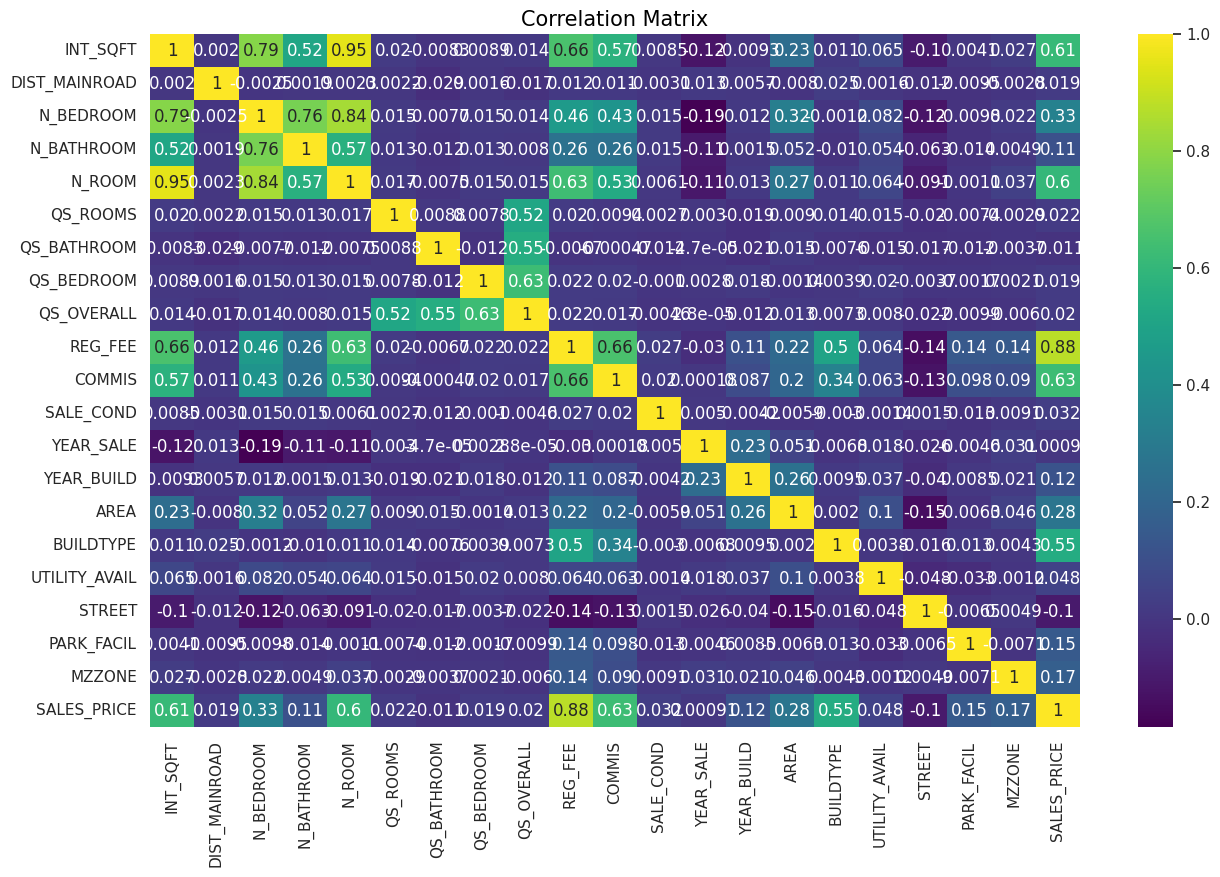

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = []
x_label = []
y_label = []

# columns = ["INT_SQFT", "DIST_MAINROAD", "N_BEDROOM", "N_BATHROOM", "N_ROOM", "QS_ROOMS" ,"QS_BATHROOM", "QS_BEDROOM", "QS_OVERALL", "REG_FEE", "COMMIS","SALES_PRICE","YEAR_SALE","YEAR_BUILD","AREA","BUILDTYPE","UTILITY_AVAIL","STREET","PARK_FACIL","MZZONE","SALE_COND"]
    
columns = ["INT_SQFT", "DIST_MAINROAD", "N_BEDROOM", "N_BATHROOM", "N_ROOM", "QS_ROOMS" ,"QS_BATHROOM", "QS_BEDROOM", "QS_OVERALL", "REG_FEE", "COMMIS","SALE_COND","YEAR_SALE","YEAR_BUILD","AREA","BUILDTYPE","UTILITY_AVAIL","STREET","PARK_FACIL","MZZONE","SALES_PRICE"]

for col in columns:
    ls = []
    for col2 in columns:
        correlation_value = df.stat.corr(col, col2)
        ls.append(correlation_value)
    corr_matrix.append(ls)
    x_label.append(col)
    y_label.append(col)

sns.set()
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
sns.heatmap(corr_matrix, xticklabels=x_label, yticklabels=y_label, annot=True, cmap='viridis')
plt.title('Correlation Matrix', fontsize = 15, c='black')
plt.show()

In [14]:
df.printSchema()

root
 |-- INT_SQFT: double (nullable = true)
 |-- DIST_MAINROAD: double (nullable = true)
 |-- N_BEDROOM: double (nullable = true)
 |-- N_BATHROOM: double (nullable = true)
 |-- N_ROOM: double (nullable = true)
 |-- QS_ROOMS: double (nullable = true)
 |-- QS_BATHROOM: double (nullable = true)
 |-- QS_BEDROOM: double (nullable = true)
 |-- QS_OVERALL: double (nullable = true)
 |-- REG_FEE: double (nullable = true)
 |-- COMMIS: double (nullable = true)
 |-- SALES_PRICE: double (nullable = true)
 |-- YEAR_SALE: double (nullable = true)
 |-- YEAR_BUILD: double (nullable = true)
 |-- AREA: double (nullable = true)
 |-- BUILDTYPE: double (nullable = true)
 |-- UTILITY_AVAIL: double (nullable = true)
 |-- STREET: double (nullable = true)
 |-- PARK_FACIL: double (nullable = true)
 |-- MZZONE: double (nullable = true)
 |-- SALE_COND: double (nullable = true)



In [15]:
df.show(30)

+--------+-------------+---------+----------+------+--------+-----------+----------+-----------------+--------+--------+-----------+---------+----------+----+---------+-------------+------+----------+------+---------+
|INT_SQFT|DIST_MAINROAD|N_BEDROOM|N_BATHROOM|N_ROOM|QS_ROOMS|QS_BATHROOM|QS_BEDROOM|       QS_OVERALL| REG_FEE|  COMMIS|SALES_PRICE|YEAR_SALE|YEAR_BUILD|AREA|BUILDTYPE|UTILITY_AVAIL|STREET|PARK_FACIL|MZZONE|SALE_COND|
+--------+-------------+---------+----------+------+--------+-----------+----------+-----------------+--------+--------+-----------+---------+----------+----+---------+-------------+------+----------+------+---------+
|  1004.0|        131.0|      1.0|       1.0|   3.0|     4.0|        3.9|       4.9|             4.33|380000.0|144400.0|  7600000.0|   2011.0|    1967.0| 0.0|      4.0|          3.0|   0.0|       2.0|   2.0|      1.0|
|  1986.0|         26.0|      2.0|       1.0|   5.0|     4.9|        4.2|       2.5|            3.765|760122.0|304049.0| 2.17177

In [16]:
def math_cal(lines,index,i):
    return (index, float(lines[i]) * float(lines[index]))
def linear_regression(data_train, X_train, y_train):
    value_X = []
    value_y = []
    data_train.createOrReplaceTempView("data")
    columns_data =""
    for i in range(len(X_train)):
        columns_data = columns_data + X_train[i] + ","
    columns_data = columns_data + y_train[0] 
    sql_data_train = spark.sql("SELECT "+ columns_data +" FROM data")
    data_train_rdd = sql_data_train.rdd
    n = data_train_rdd.count()
    value_X.append(float(n)) 
    map_X_sum = data_train_rdd.map(lambda lines: [(str(index), float(lines[index])) for index in range(len(lines))])
    flatmap_X_sum = map_X_sum.flatMap(lambda lines: lines)
    reduce_X_sum = flatmap_X_sum.reduceByKey(lambda a,b: a+b)
    data_X_sum=reduce_X_sum.collect()   
    for i in range(len(data_X_sum)):
        if(i == len(data_X_sum)-1):
            value_y.append(data_X_sum[i][1])
        else:
            value_X.append(data_X_sum[i][1])         
    for i in range (len(data_X_sum)-1):
        map_X_vol = data_train_rdd.map(lambda lines:[math_cal(lines, index, i) for index in range(len(lines))])
        flatmap_X_vol = map_X_vol.flatMap(lambda lines: lines)
        reduce_X_vol = flatmap_X_vol.reduceByKey(lambda a,b: a+b)
        data_X_vol = reduce_X_vol.collect()
        value_X.append(data_X_sum[i][1])
        for j in range(len(data_X_vol)):
            if(j == len(data_X_vol) - 1):
                value_y.append(data_X_vol[j][1])
            else:
                value_X.append(data_X_vol[j][1])       
    vector_X = np.asarray(value_X, dtype=np.float32)
    vector_X_convert=np.reshape(vector_X, (len(X_train)+1, len(X_train)+1))
    vector_y = np.asarray(value_y, dtype=np.float32)
    vector_y_convert=np.reshape(vector_y, (len(X_train)+1, 1))
    coefficient = np.linalg.lstsq(vector_X_convert, vector_y_convert)[0]     
    return coefficient

def predict(data_test, coefficient):
    y=coefficient[0].item()
    for i in range(len(data_test.columns)-1):
        y = y + data_test[i+1]*coefficient[i+1].item()
    return y

def R_square(df_predict):
    avg_price = df_predict.agg(F.mean('SALES_PRICE')).collect()[0][0]
    
    df_predict_avg = df_predict.withColumn("price_avg_log", (F.col("SALES_PRICE") - avg_price) ** 2)
    avg_price_avg_log = df_predict_avg.agg(F.mean('price_avg_log')).collect()[0][0]
    sst = avg_price_avg_log * df_predict_avg.count()
    
    df_predict_avg_price = df_predict.withColumn("price_predict_avg_log", (F.col("SALES_PRICE") - F.col("price_predict")) ** 2)
    avg_price_predict_avg_log = df_predict_avg_price.agg(F.mean('price_predict_avg_log')).collect()[0][0]
    sse = avg_price_predict_avg_log * df_predict_avg_price.count()
    
    R_square_value = 1 - (sse / sst)
    
    return R_square_value

def RMSD(df_predict, n):
    df_predict_avg_price = df_predict.withColumn("price_predict_avg_log", (F.col("SALES_PRICE") - F.col("price_predict")) ** 2)
    avg_price_predict_avg_log = df_predict_avg_price.agg(F.mean('price_predict_avg_log')).collect()[0][0]
    sse = avg_price_predict_avg_log * df_predict_avg_price.count()
    
    return math.sqrt(sse / n)

Su dung Linear Regression voi it features hon

In [17]:
df2 = df.alias("df2")
#Delete column PRT_ID
df2 = df2.drop("PRT_ID")
df2 = df2.drop("DIST_MAINROAD")
df2 = df2.drop("N_BATHROOM")
df2 = df2.drop("QS_ROOMS")
df2 = df2.drop("QS_BATHROOM")
df2 = df2.drop("QS_BEDROOM")
df2 = df2.drop("QS_OVERALL")
df2 = df2.drop("SALE_COND")
df2 = df2.drop("MZZONE")
df2 = df2.drop("PARK_FACIL")
df2 = df2.drop("STREET")
df2 = df2.drop("UTILITY_AVAIL")

In [18]:
df2.printSchema()

root
 |-- INT_SQFT: double (nullable = true)
 |-- N_BEDROOM: double (nullable = true)
 |-- N_ROOM: double (nullable = true)
 |-- REG_FEE: double (nullable = true)
 |-- COMMIS: double (nullable = true)
 |-- SALES_PRICE: double (nullable = true)
 |-- YEAR_SALE: double (nullable = true)
 |-- YEAR_BUILD: double (nullable = true)
 |-- AREA: double (nullable = true)
 |-- BUILDTYPE: double (nullable = true)



In [19]:
X_train = df2.columns
X_train.remove('SALES_PRICE')

y_train = ['SALES_PRICE']


In [20]:
# In tên các cột trong X_train
print("Các cột trong X_train:", X_train)

# In tên các cột trong y_train
print("Các cột trong y_train:", y_train)


Các cột trong X_train: ['INT_SQFT', 'N_BEDROOM', 'N_ROOM', 'REG_FEE', 'COMMIS', 'YEAR_SALE', 'YEAR_BUILD', 'AREA', 'BUILDTYPE']
Các cột trong y_train: ['SALES_PRICE']


In [21]:
data_train = df2.limit(int(df2.count() * 0.7))
data_test = df2.subtract(data_train)

coefficient = linear_regression(data_train,X_train,y_train)

/tmp/ipykernel_8472/3256623931.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefficient = np.linalg.lstsq(vector_X_convert, vector_y_convert)[0]


In [22]:
df_predict = data_test.withColumn("price_predict",predict(data_test,coefficient))
df_predict.show(30)   

+--------+---------+------+--------+--------+-----------+---------+----------+----+---------+--------------------+
|INT_SQFT|N_BEDROOM|N_ROOM| REG_FEE|  COMMIS|SALES_PRICE|YEAR_SALE|YEAR_BUILD|AREA|BUILDTYPE|       price_predict|
+--------+---------+------+--------+--------+-----------+---------+----------+----+---------+--------------------+
|  1313.0|      1.0|   3.0|332606.0|152999.0|  6652125.0|   2010.0|    2003.0| 0.0|      2.0|7.188199305289733E11|
|   950.0|      1.0|   3.0|254121.0| 81975.0|  8197450.0|   2014.0|    1999.0|12.0|      1.0|5.492044239628190...|
|  1879.0|      3.0|   5.0|349447.0| 76442.0| 1.092023E7|   2006.0|    1972.0| 5.0|      1.0|7.552181850946318E11|
|  1809.0|      3.0|   5.0|354441.0|232602.0| 1.107628E7|   2006.0|    1962.0| 5.0|      2.0|7.660141060103212E11|
|  1093.0|      1.0|   3.0|279923.0| 48263.0|  9652510.0|   2013.0|    1995.0|12.0|      2.0|6.049696762522836E11|
|  1909.0|      2.0|   5.0|782811.0|267804.0|  2.06003E7|   2009.0|    1994.0| 4

In [23]:
print("R_square: "+ str(R_square(df_predict)))
print("RMSD: "+str(RMSD(df_predict,data_test.count())))

R_square: -52457021413.09861
RMSD: 874449197734.2875
